## Get data and packages

In [1]:
import os

os.chdir(os.path.join(os.getcwd(), '..'))
import src.preprocessing
import src.model_training
import src.feature_engineering

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time
import shap
import lightgbm as lgb
import joblib

import json
import sys

from verstack import LGBMTuner
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = src.feature_engineering.get_train_data('data/data_pricing_challenge.csv')
df.head()

,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at,diesel,electro,hybrid_petrol,petrol,beige,black,blue,brown,green,grey,orange,red,silver,white,convertible,coupe,estate,hatchback,sedan,subcompact,suv,van,antiquity,avg_price,avg_mileage,avg_antiquity,avg_price_per_milleage,avg_price_per_antiquity,price_per_milleage,price_per_antiquity
0,140411,100,2012-02-01,diesel,black,convertible,1,1,0,0,1,1,1,0,11300,2018-01-01,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,5.916496,9768.79,130799.10,6.19,0.0747,1578.1567,0.0805,1909.9144
1,13929,317,2016-04-01,petrol,grey,convertible,1,1,0,0,0,1,1,1,69700,2018-02-01,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1.837098,61650.00,41669.50,2.46,1.4795,25060.9756,5.0039,37940.2757
2,183297,120,2012-04-01,diesel,white,convertible,0,0,0,0,1,0,1,0,10200,2018-02-01,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,5.837098,12427.21,153493.65,5.64,0.0810,2203.4060,0.0556,1747.4437
3,128035,135,2014-07-01,diesel,red,convertible,1,1,0,0,1,1,1,1,25100,2018-02-01,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,3.589322,23931.82,86178.64,3.74,0.2777,6398.8824,0.1960,6992.9634
4,97097,160,2014-12-01,diesel,silver,convertible,1,1,0,0,0,1,1,1,33400,2018-04-01,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,3.331964,31000.00,76673.50,3.38,0.4043,9171.5976,0.3440,10024.1167


Model Training

In [3]:
target = 'price'
variables = src.model_training.txt_load('utils/model_variables.txt')
hyperparameters = src.model_training.json_load('utils/model_hyperparameters.json')

X = df.loc[:, variables]
y = df.loc[:, [target]]

In [4]:
# Initial tune to optimize hyperparameters
# tuner = LGBMTuner(metric = 'rmse', random_state = 123)
# tuner.fit(X, y['price'])

In [5]:
X_train, X_test, y_train, y_test = src.model_training.split_dataset(df, variables, target, 0.3)

model = src.model_training.lightgbm_training(X_train, y_train, hyperparameters)

In [6]:
results = X_test.copy()
results = results.assign(
    price_real = y_test,
    price_pred = model.predict(X_test)
)
results['error'] = results['price_real'] - results['price_pred']
results.sort_values(by='error', ascending = True).head(10)

,mileage,engine_power,antiquity,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,convertible,coupe,estate,hatchback,sedan,subcompact,suv,van,avg_price,avg_mileage,avg_antiquity,avg_price_per_milleage,avg_price_per_antiquity,price_real,price_pred,error
112,12634,142,1.661875,1,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,23931.82,86178.64,3.74,0.2777,6398.8824,17800,32519.440133,-14719.440133
4459,65918,120,2.247775,1,1,1,1,0,1,1,1,0,0,0,0,0,0,1,0,17928.11,134700.06,5.46,0.1331,3283.5366,15600,27771.344129,-12171.344129
2066,66816,110,1.998631,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,20737.50,108524.12,3.22,0.1911,6440.2174,16200,27431.850039,-11231.850039
1451,174817,135,5.081451,1,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,15805.09,154519.53,5.51,0.1023,2868.4374,4800,16007.700882,-11207.700882
4706,80510,140,3.085558,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,31475.56,80901.56,3.13,0.3891,10056.0895,19000,30187.083084,-11187.083084
2948,73708,190,4.580424,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,23766.67,151130.73,6.76,0.1573,3515.7796,19200,30197.249152,-10997.249152
2851,62200,140,1.746749,0,1,0,0,1,1,1,1,0,0,0,0,1,0,0,0,15805.09,154519.53,5.51,0.1023,2868.4374,16700,27398.050397,-10698.050397
3074,82647,230,3.663244,1,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,37772.22,126482.94,4.85,0.2986,7788.0866,32600,43028.283873,-10428.283873
2060,66690,135,3.832991,1,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,24427.27,81601.36,3.23,0.2993,7562.6223,13200,23415.983901,-10215.983901
746,44211,160,4.413415,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,16038.64,167663.14,6.44,0.0957,2490.4720,7600,17656.935674,-10056.935674


In [7]:
import plotly.express as px

max_value = 70000

fig = px.scatter(results, x='price_real', y='price_pred', title='Price Real vs Pred', width = 700, height = 700)

# Agregar la línea y=x en rojo
fig.add_trace(px.line(x=[0, max_value], y=[0, max_value]).update_traces(line_shape='linear', line_color='red').data[0])

fig.update_xaxes(range=[0, max_value])
fig.update_yaxes(range=[0, max_value])

fig.show()

Plots and Model Performance Analysis

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

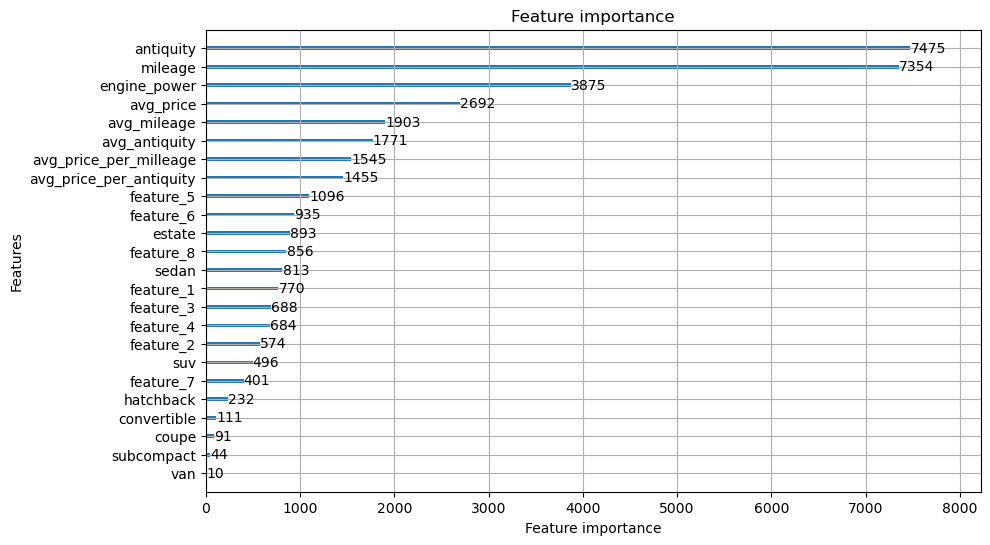

In [8]:
lgb.plot_importance(model, max_num_features=30, figsize=(10, 6))

In [9]:
src.model_training.model_results(model, X_train, X_test, y_train, y_test)

Model Results:

RMSE train: 1699.7547802414329
RMSE test: 2560.9114339829257

MAE train: 1164.5605025069895
MAE test: 1715.6693908956079

R2 train: 0.956995631552121
R2 test: 0.9165192822995551


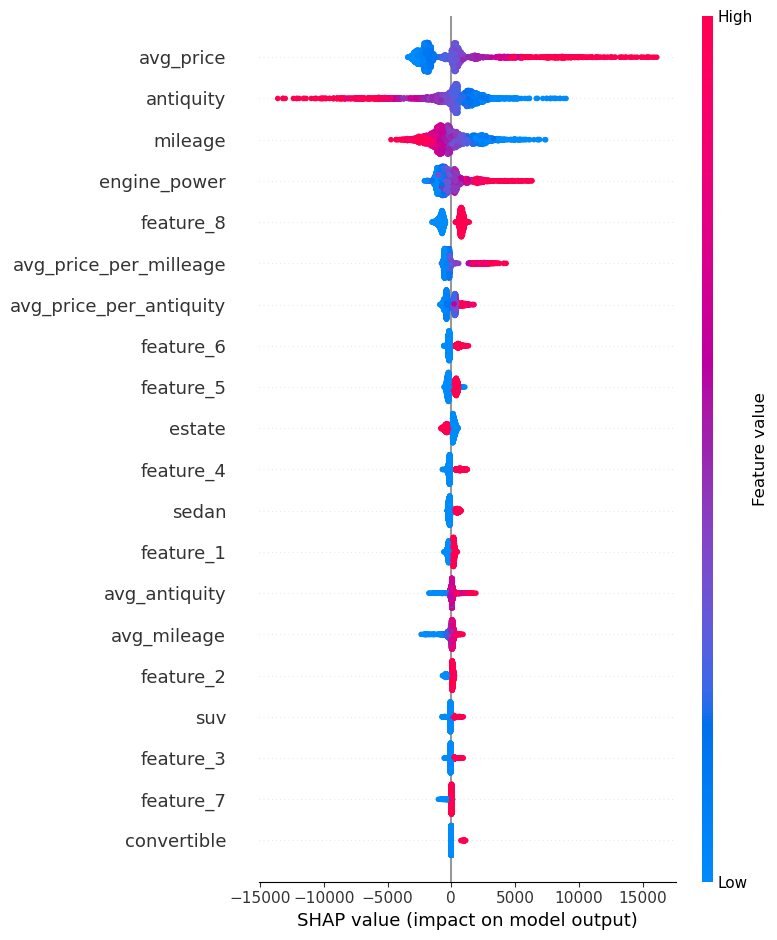

In [10]:
explainer, shap_values = src.model_training.calculate_shap_values(model, X_train)

# Visualize Shapley values
shap.summary_plot(shap_values, X_train)

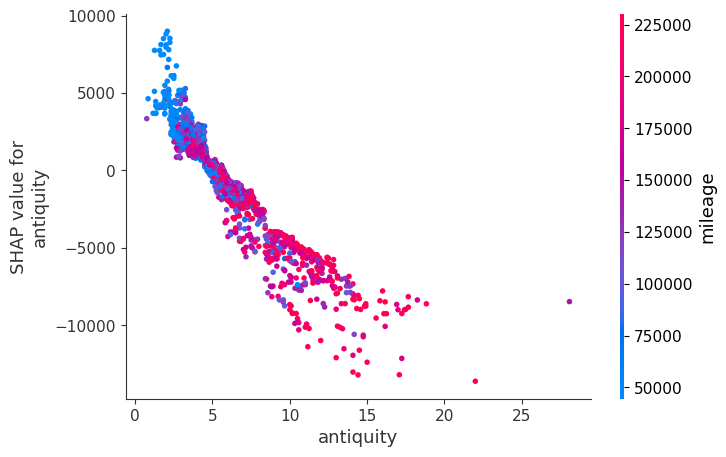

In [20]:
feature_names = X_train.columns.tolist()

# Seleccionar las variables que te interesan (puedes usar los nombres directamente)
variable1_name = 'antiquity'
variable2_name = 'mileage'

# Encontrar los índices correspondientes a los nombres de las variables
variable1_index = feature_names.index(variable1_name)
variable2_index = feature_names.index(variable2_name)

# Crear un Dependence Plot
shap.dependence_plot(variable1_index, shap_values, X_train, feature_names=feature_names, interaction_index=variable2_index, show=False)
plt.show()

In [14]:
src.model_training.save_model(model, '\model')